# tcplife-bpfcc Log Analysis

## Functionalities
- Plot active number of TCP sessions.

## Input
Log files are read from a directory in `../data`. This directory is assumed to have the following structure:
```
logs/
  [node-1]/
    tcplife-bpfcc.tar.gz
  ...
  [node-n]/
    tcplife-bpfcc.tar.gz
```
A tarball `tcplife-bpfcc.tar.gz` contains a log file named `tcplife-bpfcc.log`.

## Notebook Configuration

In [1]:
########## GENERAL
# Name of the directory in `../data`
EXPERIMENT_DIRNAME = "BuzzBlogBenchmark_2021-10-10-18-35-22"

########## TCP SESSION
# Address of interest
ADDR_PORT = "155.98.36.15:5435"
# Window size
WINDOW_IN_MS = 10

## Notebook Setup

In [2]:
# Import libraries.
%matplotlib inline
import codecs
import csv
import matplotlib.pyplot as plt
import os
import pandas as pd
import tarfile
import warnings
warnings.filterwarnings("ignore")

## Log Parsing

In [3]:
# Parse logs
tcp_sessions = {"node_name": [], "timestamp": [], "comm": [], "addr_port": [], "duration": []}
node_names = os.listdir(os.path.join(os.pardir, "data", EXPERIMENT_DIRNAME, "logs"))
for node_name in node_names:
  tarball_path = os.path.join(os.pardir, "data", EXPERIMENT_DIRNAME, "logs", node_name, "tcplife-bpfcc.tar.gz")
  if os.path.exists(tarball_path):
    with tarfile.open(tarball_path, "r:gz") as tar:
      for filename in tar.getnames():
        if filename.endswith("tcplife-bpfcc.log"):
          with tar.extractfile(filename) as log_file:
            reader = csv.DictReader(codecs.getreader("utf-8")(log_file))
            for row in reader:
              if row["RPORT"]:
                tcp_sessions["node_name"].append(node_name)
                tcp_sessions["timestamp"].append(float(row["TIME(s)"]))
                tcp_sessions["comm"].append(row["COMM"])
                tcp_sessions["addr_port"].append(row["RADDR"] + ":" + row["RPORT"])
                tcp_sessions["duration"].append(float(row["MS"]))

In [4]:
# Build data frame
tcp_sessions = pd.DataFrame.from_dict(tcp_sessions)
tcp_sessions["window"] = tcp_sessions.apply(lambda r: range(int(r["timestamp"] * 1000) // WINDOW_IN_MS,
    int((r["timestamp"] + r["duration"] / 1000) * 1000) // WINDOW_IN_MS + 1), axis=1)
tcp_sessions = tcp_sessions.explode("window")

## Number of Active TCP Sessions

<AxesSubplot:title={'center':'155.98.36.15:5435 - Number of active TCP sessions (10-millisecond window)'}, xlabel='Time (s)', ylabel='TCP sessions (count)'>

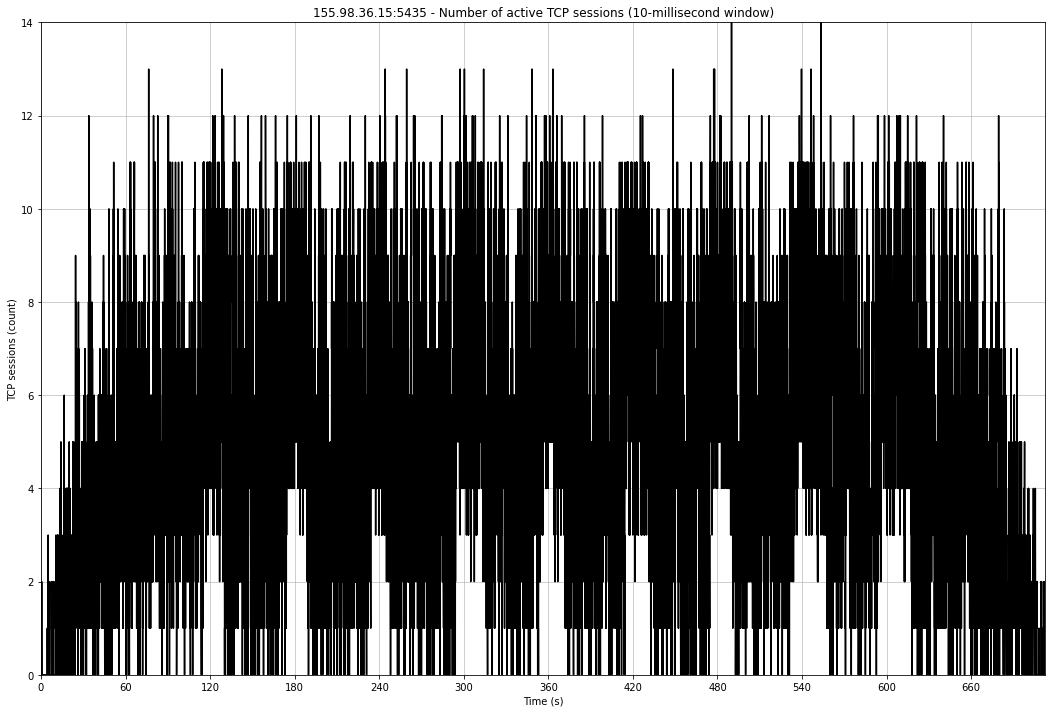

In [5]:
df = tcp_sessions[tcp_sessions["addr_port"] == ADDR_PORT]
df = df.groupby(["window"])["window"].count()
df = df.reindex(range(0, int(df.index.max()) + 1), fill_value=0)
fig = plt.figure(figsize=(18, 12))
ax = fig.gca()
ax.grid(alpha=0.75)
ax.set_xlim((df.index.min(), df.index.max()))
ax.set_ylim((0, df.values.max()))
ax.set_xticklabels([str(i * 60) for i, _ in enumerate(range(0, int(df.index.max()) + 1, 60 * (1000 // WINDOW_IN_MS)))])
df.plot(ax=ax, kind="line",
    title="%s - Number of active TCP sessions (%s-millisecond window)" % (ADDR_PORT, WINDOW_IN_MS),
    xlabel="Time (s)", ylabel="TCP sessions (count)", color="black", grid=True,
    xticks=range(0, int(df.index.max()) + 1, 60 * (1000 // WINDOW_IN_MS)))